In [2]:
import torch

input = torch.tensor([[1.0, 2.0, 3.0], [1.0, 1.0, 1.0]])
m = torch.nn.LayerNorm(input.shape[-1])
print(input.shape)     # 배치 크기(2) x 피처 차원 수(3)
print(input.shape[-1]) # -> 방향으로 레이어 정규화 수행
output = m(input)
print(output)

torch.Size([2, 3])
3
tensor([[-1.2247,  0.0000,  1.2247],
        [ 0.0000,  0.0000,  0.0000]], grad_fn=<NativeLayerNormBackward0>)


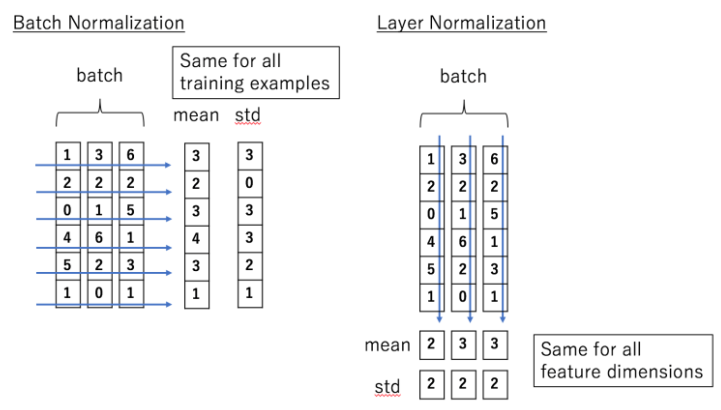

배치정규화는 이전레이어에 가중치를 곱한 결과(액티베이션 출력값)를 채널별로 정규화한다.
채널수(특징 수) 만큼의 평균과 분산을 계산해야 한다.


레이어 정규화는 데이터별로 정규화한다.
그러므로 미니배치 수만큼의 평균과 분산을 계산해야 한다.

a = X * w + b 일때 

배치   정규화 : (a - 채널별 평균(a)) / root(채널별 분산(a)+epsilon) * gamma + beta

레이어 정규화 : (a - 데이터별 평균(a)) / root(데이터별 분산(a)+epsilon) * gamma + beta 

학습 초기 레이어 정규화 수행은 배치 인스턴스의 평균을 빼고 표준편차로 나눈 결과에 1을 곱한 후 0을 더한다는 뜻 -> 이후 학습 과정에서는 태스크를 가장 잘 수행하는 방향으로 이 값들을 업데이트 한다

In [9]:
print(m.weight)
print(m.bias)

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


파이토치로 레이어 정규화 수행

In [7]:
import numpy as np

a = np.array([[1.0, 2.0, 3.0], [1.0, 1.0, 1.0]]) # (2,3)
a_mean = np.mean(a, axis=1)
a_std = np.std(a, axis=1)
print(a_mean)
print(a_std)

[2. 1.]
[0.81649658 0.        ]


드롭아웃: 과적합 현상을 방지하고자 뉴런의 일부를 확률적으로 0으로 대치하여 계산에서 제외하는 기법(학습 과정에서만 적용하고 학습이 끝나고 나서 인퍼런스 과정에서는 적용하지 않는다)

In [16]:
m = torch.nn.Dropout(p=0.2)
input = torch.randn(1,10)
output = m(input)
output

tensor([[-0.0000, -1.1091,  3.5014, -0.4430,  1.2754,  0.8814,  0.0000, -1.3042,
          0.3551, -0.5158]])

In [ ]:
# from torch.optim import Adam
# optimizer = Adam(model.parameters(), lr=model.learning_rate)

In [17]:
import torch

# The autograd package provides automatic differentiation 
# for all operations on Tensors
# requires_grad = True -> tracks all operations on the tensor. 

x = torch.randn(3, requires_grad=True)
print(x)
y = x + 2
print(y)
z = y * y * 3
print(z)
z = z.mean()
print(z) # scalar

tensor([-2.0856, -0.6685,  1.6294], requires_grad=True)
tensor([-0.0856,  1.3315,  3.6294], grad_fn=<AddBackward0>)
tensor([2.2003e-02, 5.3183e+00, 3.9518e+01], grad_fn=<MulBackward0>)
tensor(14.9528, grad_fn=<MeanBackward0>)


x = torch.randn(3, requires_grad=False) 하면 z.backward()에서 에러뜬다

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [18]:
# Let's compute the gradients with backpropagation
# When we finish our computation we can call .backward() and have all the gradients computed automatically.
# The gradient for this tensor will be accumulated into .grad attribute.
# It is the partial derivate of the function w.r.t. the tensor

z.backward()
print(x.grad) # dz/dx

tensor([-0.1713,  2.6629,  7.2589])


Generally speaking, torch.autograd is an engine for computing vector-Jacobian product  
It computes partial derivates while applying the chain rule

-------------
Model with non-scalar output:<br>
If a Tensor is non-scalar (more than 1 elements), we need to specify arguments for backward()<br>
specify a gradient argument that is a tensor of matching shape.  
needed for vector-Jacobian product

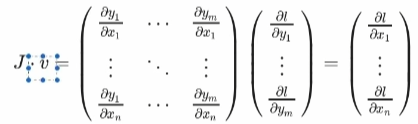

In [21]:
import torch

# The autograd package provides automatic differentiation 
# for all operations on Tensors
# requires_grad = True -> tracks all operations on the tensor. 

x = torch.randn(3, requires_grad=True)
print(x)
y = x + 2
print(y)
z = y * y * 3
print(z) # vector(1 x 3) -> [20.0856, 20.0242, 40.4575]

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float32)
z.backward(v)
print(x.grad) # dz/dx

tensor([ 1.1642,  0.5378, -0.7660], requires_grad=True)
tensor([3.1642, 2.5378, 1.2340], grad_fn=<AddBackward0>)
tensor([30.0373, 19.3215,  4.5679], grad_fn=<MulBackward0>)
tensor([1.8985e+00, 1.5227e+01, 7.4037e-04])


Stop a tensor from tracking history:
For example during our training loop when we want to update our weights
then this update operation should not be part of the gradient computation
- x.requires_grad_(False)
- x.detach()
- wrap in 'with torch.no_grad():'

In [23]:
x = torch.randn(3, requires_grad=True)
print(x)
x.requires_grad_(False) # inplace 방식으로 바뀐다
print(x)

tensor([-0.5801, -2.4290,  0.4684], requires_grad=True)
tensor([-0.5801, -2.4290,  0.4684])


In [24]:
x = torch.randn(3, requires_grad=True)
print(x)
y = x.detach() # value는 같지만 requires_grad가 사라진다
print(y)

tensor([-0.2619,  0.2732,  0.6119], requires_grad=True)
tensor([-0.2619,  0.2732,  0.6119])


In [27]:
x = torch.randn(3, requires_grad=True)
print(x)
y = x+2
print(y)
print()

x = torch.randn(3, requires_grad=True)
print(x)
with torch.no_grad():
    y = x+2
    print(y)
    

tensor([ 0.0433,  1.7821, -2.0024], requires_grad=True)
tensor([ 2.0433e+00,  3.7821e+00, -2.3713e-03], grad_fn=<AddBackward0>)

tensor([-2.0201,  0.0037, -0.9413], requires_grad=True)
tensor([-0.0201,  2.0037,  1.0587])


In [31]:
weights = torch.ones(4, requires_grad=True)

for epoch in range(3):
    # just a dummy example
    model_output = (weights*3).sum()
    print("model_output: ", model_output)
    model_output.backward()
    
    print("weights.grad: ", weights.grad)

model_output:  tensor(12., grad_fn=<SumBackward0>)
weights.grad:  tensor([3., 3., 3., 3.])
model_output:  tensor(12., grad_fn=<SumBackward0>)
weights.grad:  tensor([6., 6., 6., 6.])
model_output:  tensor(12., grad_fn=<SumBackward0>)
weights.grad:  tensor([9., 9., 9., 9.])


backward() accumulates the gradient for this tensor into .grad attribute.  
!!! We need to be careful during optimization !!!  
Use .zero_() to empty the gradients before a new optimization step!

In [57]:
weights = torch.ones(4, requires_grad=True)

for epoch in range(3):
    # just a dummy example
    print(epoch)
    model_output = (weights*3).sum()
    model_output.backward()
    
    print(weights.grad)

    # optimize model, i.e. adjust weights...
    with torch.no_grad():
        weights -= 0.01 * weights.grad

    # this is important! It affects the final weights & output
    weights.grad.zero_()

print(weights)
print(model_output)


0
tensor([3., 3., 3., 3.])
1
tensor([3., 3., 3., 3.])
2
tensor([3., 3., 3., 3.])
tensor([0.9100, 0.9100, 0.9100, 0.9100], requires_grad=True)
tensor(11.2800, grad_fn=<SumBackward0>)


In [59]:
weights2 = torch.ones(4, requires_grad=True)

for epoch in range(3):
    # just a dummy example
    print(epoch)
    model_output = (weights2*3).sum()
    model_output.backward()
    
    print(weights2.grad)

    # optimize model, i.e. adjust weights...
    optimizer = torch.optim.SGD([weights2], lr=0.01)
    optimizer.step()
    optimizer.zero_grad()

print(weights2)
print(model_output)

0
tensor([3., 3., 3., 3.])
1
tensor([3., 3., 3., 3.])
2
tensor([3., 3., 3., 3.])
tensor([0.9100, 0.9100, 0.9100, 0.9100], requires_grad=True)
tensor(11.2800, grad_fn=<SumBackward0>)


- Forward pass: Compute Loss
- Compute local gradient
- Backward pass: Compute dLoss / dWeights using the Chain Rule

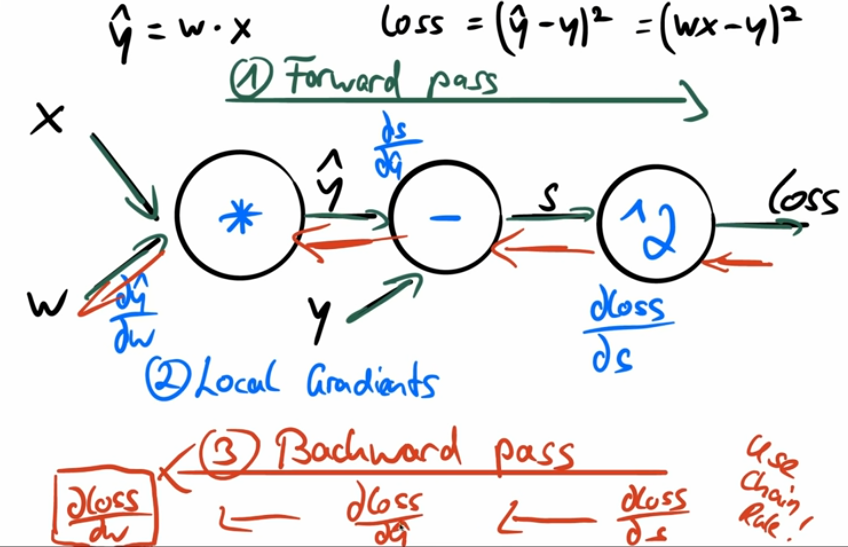

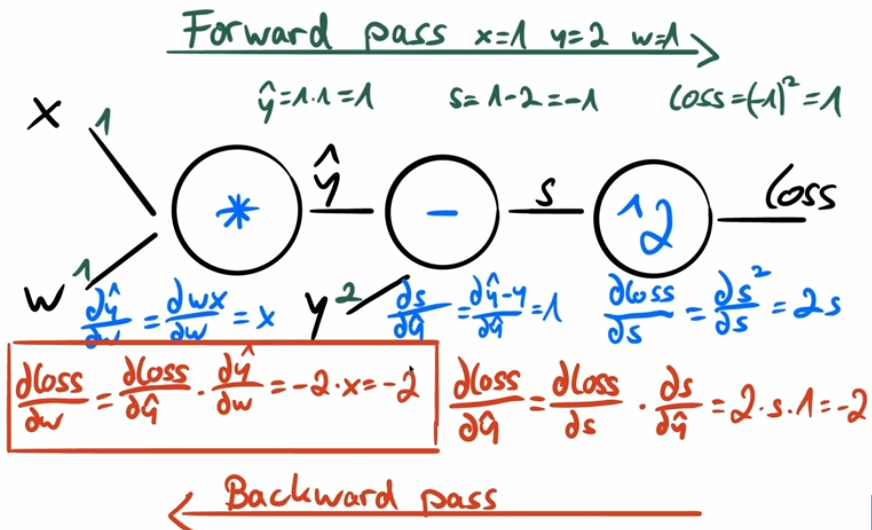

In [75]:
import torch

x = torch.tensor(1.0)
y = torch.tensor(2.0)

# This is the parameter we want to optimize -> requires_grad=True
w = torch.tensor(1.0, requires_grad=True)

# forward pass to compute loss
y_predicted = w * x
loss = (y_predicted - y)**2
print(loss)

# backward pass to compute gradient dLoss/dw
loss.backward()
print(w.grad)

tensor(1., grad_fn=<PowBackward0>)
tensor(-2.)


In [76]:
with torch.no_grad():
    w -= 0.01 * w.grad
# don't forget to zero the gradients
w.grad.zero_()
print(w)

tensor(1.0200, requires_grad=True)


In [77]:
y_predicted = w * x
loss = (y_predicted - y)**2
print(loss)

tensor(0.9604, grad_fn=<PowBackward0>)


업데이트된 w로 loss를 계산할 때마다 값이 줄어든다.!

In [74]:
import torch

x = torch.tensor(1.0)
y = torch.tensor(2.0)

# This is the parameter we want to optimize -> requires_grad=True
w = torch.tensor(1.0, requires_grad=True)

for epoch in range(10):
    # forward pass to compute loss
    y_predicted = w * x
    loss = (y_predicted - y)**2
    print(f'{epoch+1}: w:{w} -> loss:{loss}')

    # backward pass to compute gradient dLoss/dw
    loss.backward()
    print(w.grad)
    with torch.no_grad():
        w -= 0.01 * w.grad
    # don't forget to zero the gradients
    w.grad.zero_()
    

1: w:1.0 -> loss:1.0
tensor(-2.)
2: w:1.0199999809265137 -> loss:0.9604000449180603
tensor(-1.9600)
3: w:1.0396000146865845 -> loss:0.9223681092262268
tensor(-1.9208)
4: w:1.0588079690933228 -> loss:0.8858424425125122
tensor(-1.8824)
5: w:1.0776318311691284 -> loss:0.8507630228996277
tensor(-1.8447)
6: w:1.0960792303085327 -> loss:0.8170727491378784
tensor(-1.8078)
7: w:1.1141576766967773 -> loss:0.7847166061401367
tensor(-1.7717)
8: w:1.1318745613098145 -> loss:0.7536417841911316
tensor(-1.7363)
9: w:1.149237036705017 -> loss:0.723797619342804
tensor(-1.7015)
10: w:1.1662522554397583 -> loss:0.6951352953910828
tensor(-1.6675)
